# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [2]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-04-16 19:22:38--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  36.7MB/s    in 5.9s    

2021-04-16 19:22:44 (29.4 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-04-16 19:22:44--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  36.8MB/s    in 1.7s    

2021-04-16 19:22:46 (36.8 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-04-16 19:22:46--
Total wall clock time: 7.8s
Downloaded: 2 files, 235M i

In [3]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [4]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [5]:
import platform
platform.machine()

'x86_64'

In [6]:
platform.version()

'#1 SMP Thu Jul 23 08:00:38 PDT 2020'

In [7]:
platform.platform()

'Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic'

In [8]:
platform.uname()

uname_result(system='Linux', node='8fe328f2963b', release='4.19.112+', version='#1 SMP Thu Jul 23 08:00:38 PDT 2020', machine='x86_64', processor='x86_64')

In [9]:
platform.processor()

'x86_64'

# Загружаем данные

In [10]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [11]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [12]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [13]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [14]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        if scheduler is not None:
            scheduler.step(ave_loss)
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct = 0 
    total = 0 
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
                x = x.to(device)
                y = y.to(device)
                prediction = torch.argmax(model(x) , 1)    
                for i in range(len(prediction)):
                    if prediction[i] == y[i]:
                        correct += 1
                total += len(prediction)
    return float(correct/total)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.409753, Train accuracy: 0.527523, Val accuracy: 0.768139
Average loss: 0.708965, Train accuracy: 0.784698, Val accuracy: 0.798785
Average loss: 0.604430, Train accuracy: 0.819097, Val accuracy: 0.805815
Average loss: 0.555310, Train accuracy: 0.834300, Val accuracy: 0.826565
Average loss: 0.523421, Train accuracy: 0.845016, Val accuracy: 0.826496


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [15]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


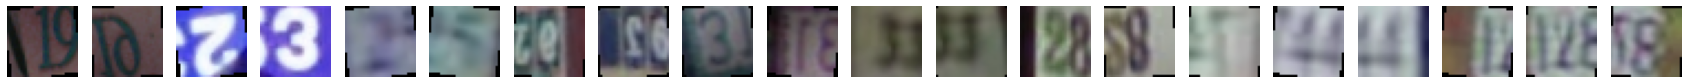

In [16]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 20:
        break
    plt.subplot(1, 20, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [17]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [18]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 1.514440, Train accuracy: 0.473945, Val accuracy: 0.569176
Average loss: 1.293198, Train accuracy: 0.546787, Val accuracy: 0.601119
Average loss: 1.219015, Train accuracy: 0.577620, Val accuracy: 0.625282
Average loss: 1.179416, Train accuracy: 0.592090, Val accuracy: 0.606989
Average loss: 1.145853, Train accuracy: 0.605928, Val accuracy: 0.658249


In [19]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)


loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Average loss: 0.913330, Train accuracy: 0.707061, Val accuracy: 0.700976
Average loss: 0.845153, Train accuracy: 0.730249, Val accuracy: 0.771551
Average loss: 0.816413, Train accuracy: 0.739071, Val accuracy: 0.762269
Average loss: 0.792710, Train accuracy: 0.748985, Val accuracy: 0.760562
Average loss: 0.774683, Train accuracy: 0.754650, Val accuracy: 0.776398


In [20]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)


loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Average loss: 0.868316, Train accuracy: 0.721820, Val accuracy: 0.765886
Average loss: 0.749668, Train accuracy: 0.761816, Val accuracy: 0.775715
Average loss: 0.721797, Train accuracy: 0.773129, Val accuracy: 0.791891
Average loss: 0.700903, Train accuracy: 0.779391, Val accuracy: 0.796123
Average loss: 0.687858, Train accuracy: 0.781848, Val accuracy: 0.790868


In [21]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)


loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.519418, Train accuracy: 0.843685, Val accuracy: 0.840420
Average loss: 0.464445, Train accuracy: 0.861448, Val accuracy: 0.833322
Average loss: 0.442821, Train accuracy: 0.866788, Val accuracy: 0.860624
Average loss: 0.427282, Train accuracy: 0.872419, Val accuracy: 0.865197
Average loss: 0.415863, Train accuracy: 0.875729, Val accuracy: 0.872432


In [22]:
# TODO: 
tfs = transforms.Compose([
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)


loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Average loss: 0.455159, Train accuracy: 0.862198, Val accuracy: 0.864651
Average loss: 0.440313, Train accuracy: 0.866874, Val accuracy: 0.865879
Average loss: 0.434495, Train accuracy: 0.868119, Val accuracy: 0.867518
Average loss: 0.428959, Train accuracy: 0.870525, Val accuracy: 0.862740
Average loss: 0.424276, Train accuracy: 0.872556, Val accuracy: 0.872568


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [23]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(6),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    Flattener(),
    nn.Linear(16*5*5, 120),
    nn.BatchNorm1d(120),
    nn.ReLU(inplace=True),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10),
    nn.BatchNorm1d(10))
lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [24]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 0.779102, Train accuracy: 0.759786, Val accuracy: 0.864446
Average loss: 0.489007, Train accuracy: 0.851227, Val accuracy: 0.883626
Average loss: 0.426367, Train accuracy: 0.871122, Val accuracy: 0.894273
Average loss: 0.392053, Train accuracy: 0.880644, Val accuracy: 0.894000
Average loss: 0.363405, Train accuracy: 0.889721, Val accuracy: 0.902259
Average loss: 0.344000, Train accuracy: 0.894823, Val accuracy: 0.903351
Average loss: 0.327543, Train accuracy: 0.899413, Val accuracy: 0.907993
Average loss: 0.313986, Train accuracy: 0.904293, Val accuracy: 0.908675
Average loss: 0.301504, Train accuracy: 0.908491, Val accuracy: 0.910313
Average loss: 0.292809, Train accuracy: 0.911579, Val accuracy: 0.911610


# Подбор гиперпараметров

In [27]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

def new_lenet():
    return nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(6),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    Flattener(),
    nn.Linear(16*5*5, 120),
    nn.BatchNorm1d(120),
    nn.ReLU(inplace=True),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10),
    nn.BatchNorm1d(10))
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history' ,'final_val_accuracy' ])

learning_rates = [1e-3, 2e-3, 4e-3, 1e-4, 2e-4, 3e-4]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

best_model = None
best_accuracy = 0

for lr in learning_rates:
  for rg in reg:
    print("lr: " , lr, " rg: ",rg)
    lenet_model = new_lenet()
    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)
    optimizer = optim.Adam(lenet_model.parameters(), lr=lr, weight_decay=rg)
    sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= False)
    loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, sheduler)  
    if val_history[-1] > best_accuracy:
      best_model = lenet_model 
    run_record[Hyperparams(lr, rg)] = RunResult(lenet_model, train_history, val_history , val_history[-1])

lr:  0.001  rg:  0.001
Average loss: 1.052153, Train accuracy: 0.689264, Val accuracy: 0.850795
Average loss: 0.576649, Train accuracy: 0.834983, Val accuracy: 0.880076
Average loss: 0.492345, Train accuracy: 0.856619, Val accuracy: 0.885264
Average loss: 0.448369, Train accuracy: 0.867880, Val accuracy: 0.888950
Average loss: 0.418445, Train accuracy: 0.876634, Val accuracy: 0.893318
Average loss: 0.401111, Train accuracy: 0.880166, Val accuracy: 0.894410
Average loss: 0.386774, Train accuracy: 0.885438, Val accuracy: 0.903215
Average loss: 0.366797, Train accuracy: 0.890660, Val accuracy: 0.899734
Average loss: 0.362492, Train accuracy: 0.892247, Val accuracy: 0.902191
Average loss: 0.350619, Train accuracy: 0.894994, Val accuracy: 0.900962
lr:  0.001  rg:  0.0001
Average loss: 0.954446, Train accuracy: 0.725506, Val accuracy: 0.860692
Average loss: 0.553368, Train accuracy: 0.839880, Val accuracy: 0.885742
Average loss: 0.470676, Train accuracy: 0.861840, Val accuracy: 0.895434
Aver

In [28]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.92, best hyperparams: Hyperparams(learning_rate=0.002, reg=1e-07)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [30]:
lenet_model = new_lenet()
lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)
optimizer = optim.Adam(lenet_model.parameters(), lr=0.002, weight_decay=1e-07)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= False)
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 30, sheduler)

Average loss: 0.830260, Train accuracy: 0.756646, Val accuracy: 0.868268
Average loss: 0.518488, Train accuracy: 0.844060, Val accuracy: 0.884513
Average loss: 0.446766, Train accuracy: 0.865816, Val accuracy: 0.895570
Average loss: 0.407721, Train accuracy: 0.877163, Val accuracy: 0.893796
Average loss: 0.374418, Train accuracy: 0.887213, Val accuracy: 0.903693
Average loss: 0.356093, Train accuracy: 0.892690, Val accuracy: 0.904989
Average loss: 0.335041, Train accuracy: 0.897058, Val accuracy: 0.909085
Average loss: 0.321036, Train accuracy: 0.902467, Val accuracy: 0.910791
Average loss: 0.308183, Train accuracy: 0.906051, Val accuracy: 0.913999
Average loss: 0.297092, Train accuracy: 0.909327, Val accuracy: 0.909699
Average loss: 0.280195, Train accuracy: 0.915367, Val accuracy: 0.910177
Average loss: 0.276802, Train accuracy: 0.915777, Val accuracy: 0.912770
Average loss: 0.266681, Train accuracy: 0.918490, Val accuracy: 0.915842
Average loss: 0.257305, Train accuracy: 0.920725, V

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [31]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = compute_accuracy(lenet_model, torch.utils.data.DataLoader(data_test, batch_size=batch_size))
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9038875230485556
